In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.ioff()

## Memory Management

In [2]:
import warnings
warnings.simplefilter(action="always", category=RuntimeWarning)

In [3]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))

/Users/croach/anaconda/envs/mpl/lib/python2.7/site-packages/matplotlib/pyplot.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [4]:
plt.get_fignums()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

### Why does this happen?

By default, the `pylot` plotting functions do not close figures as they're used. Instead, `pyplot` registers an event listener that destroys all figures in memory when your script comes to an end. While the script is running, however, the `pyplot` interface does actively manage memory by reusing a single figure over and over again. Basically, every time a figure is rendered (output to a file or displayed in a window) `pyplot` will clear the figure and reuse it for the next set of plotting commands. It grabs the current figure from the top of global stack, and it always checks the stack for a figure before it creates a new one. If the user calls the `figure` function directly, they bypass this check and create a new figure and add it to the top of the stack, and `pyplot` just uses that whenever plotting commands are called. This means that each time the figure 

In [5]:
plt.close("all")

In [6]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))
    plt.close()

Now we no longer get a warning because we are closing each figure manually after we're finished with it.

In [7]:
plt.get_fignums()

[]

However, for the interactive backends (e.g., UI and Jupyter notebook), the `_pylab_helpers.destroy` function is called once the figure is shown. So, we end up with only 1 active figure in the queue at all times. So, every at every iteration, we call the `figure` function to create a new figure, show it, then close it and start all over. So, every iteration has a brand new figure.

NOTE TO SELF: not sure if I want to use the logger function again on this example. My main reasoning behind it was to show that the close function gets called and it's useful to see the figure being created again every time through the loop, but not sure if it adds value, or if it's just a bit too cluttered.

In [8]:
class PrintlnFunc(object):
    def __init__(self):
        self.line = 1
    def __call__(self, msg):
        print "%2d. %s" % (self.line, msg)
        self.line += 1
    def reset(self):
        self.line = 1
println = PrintlnFunc()

class Logger(object):
    """Wraps a function in a callable that prints call information
    """
    level = 0

    def __init__(self, fn):
        self.fn = fn

    def __call__(self, *args, **kwargs):
        # Create the padding string according to the current level in the call
        # stack, and increase the level since we're about to pop another 
        # function onto the stack.
        padding = "|" + "-" * (Logger.level * 4 - 1) if Logger.level > 0 else ""
        Logger.level += 1

        # Print calling information, call the function, and print returning info
        println("%sCalling %s.%s" % (padding, self.fn.__module__, self.fn.__name__))
        result = self.fn(*args, **kwargs)
        println("%sReturning <%s:%s> from %s.%s" % \
            (padding, result.__class__.__name__, id(result), self.fn.__module__, self.fn.__name__))

        # Decrease the call stack level, since we are returning.
        Logger.level -= 1
        return result
    
# Decorate several methods with the logger
plt.gca = Logger(plt.gca)
plt.gcf = Logger(plt.gcf)
plt.figure = Logger(plt.figure)
plt.close = Logger(plt.close)

# To decorate the methods on the Figure class, we have to wrap 
# our logger in a MethodType instance.
import types

# We're logging calls to the add_subplot method on the Figure
# class because this is where new Axes objects are created.
from matplotlib.figure import Figure
Figure.gca = types.MethodType(Logger(Figure.gca), None, Figure)
Figure.add_subplot = types.MethodType(Logger(Figure.add_subplot), None, Figure)

In [9]:
plt.close("all")

 1. Calling matplotlib.pyplot.close
 2. Returning <NoneType:4296531008> from matplotlib.pyplot.close


 3. Calling matplotlib.pyplot.figure
 4. Returning <Figure:4420018704> from matplotlib.pyplot.figure
 5. Calling matplotlib.pyplot.gca
 6. |---Calling matplotlib.pyplot.gcf
 7. |---Returning <Figure:4420018704> from matplotlib.pyplot.gcf
 8. |---Calling matplotlib.figure.gca
 9. |-------Calling matplotlib.figure.add_subplot
10. |-------Returning <AxesSubplot:4419457104> from matplotlib.figure.add_subplot
11. |---Returning <AxesSubplot:4419457104> from matplotlib.figure.gca
12. Returning <AxesSubplot:4419457104> from matplotlib.pyplot.gca


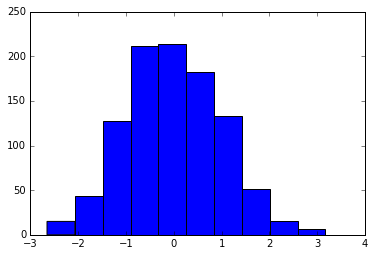

13. Calling matplotlib.pyplot.close
14. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4405616208> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4405616208> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4403532368> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4403532368> from matplotlib.figure.gca
10. Returning <AxesSubplot:4403532368> from matplotlib.pyplot.gca


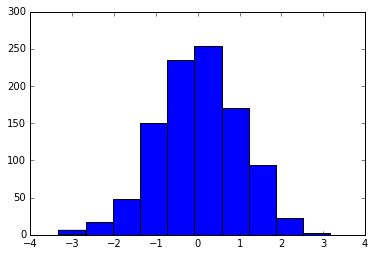

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4419809488> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4419809488> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4419868112> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4419868112> from matplotlib.figure.gca
10. Returning <AxesSubplot:4419868112> from matplotlib.pyplot.gca


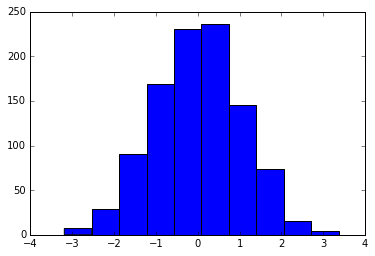

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4417989648> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4417989648> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4400646864> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4400646864> from matplotlib.figure.gca
10. Returning <AxesSubplot:4400646864> from matplotlib.pyplot.gca


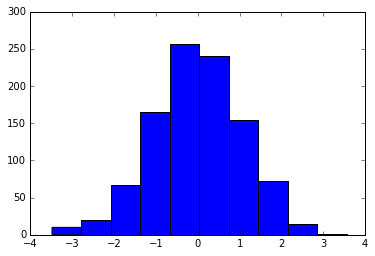

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4426296976> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4426296976> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4426085264> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4426085264> from matplotlib.figure.gca
10. Returning <AxesSubplot:4426085264> from matplotlib.pyplot.gca


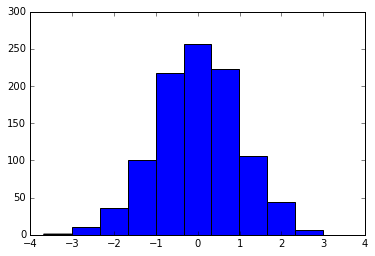

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4404215568> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4404215568> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4399879952> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4399879952> from matplotlib.figure.gca
10. Returning <AxesSubplot:4399879952> from matplotlib.pyplot.gca


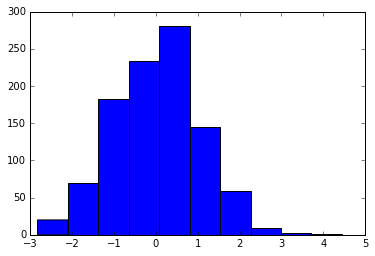

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4410788880> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4410788880> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4410361168> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4410361168> from matplotlib.figure.gca
10. Returning <AxesSubplot:4410361168> from matplotlib.pyplot.gca


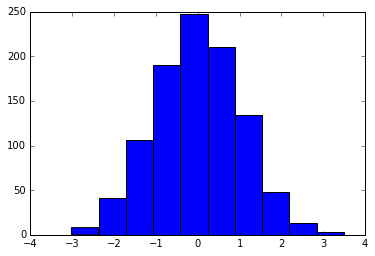

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4417642256> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4417642256> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4414837264> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4414837264> from matplotlib.figure.gca
10. Returning <AxesSubplot:4414837264> from matplotlib.pyplot.gca


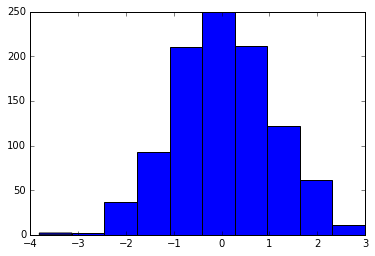

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4410754896> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4410754896> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4415430352> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4415430352> from matplotlib.figure.gca
10. Returning <AxesSubplot:4415430352> from matplotlib.pyplot.gca


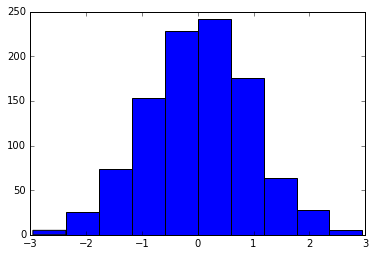

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4399879760> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4399879760> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4426445904> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4426445904> from matplotlib.figure.gca
10. Returning <AxesSubplot:4426445904> from matplotlib.pyplot.gca


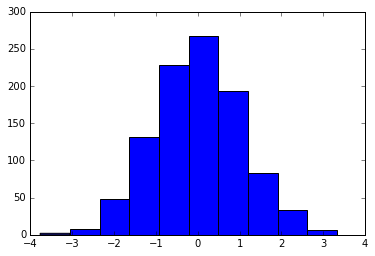

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4397833552> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4397833552> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4415026960> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4415026960> from matplotlib.figure.gca
10. Returning <AxesSubplot:4415026960> from matplotlib.pyplot.gca


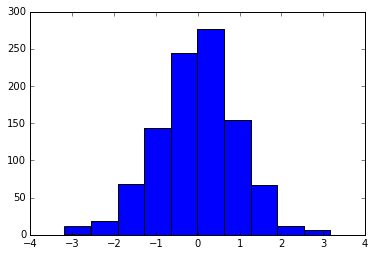

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4399920592> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4399920592> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4399895632> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4399895632> from matplotlib.figure.gca
10. Returning <AxesSubplot:4399895632> from matplotlib.pyplot.gca


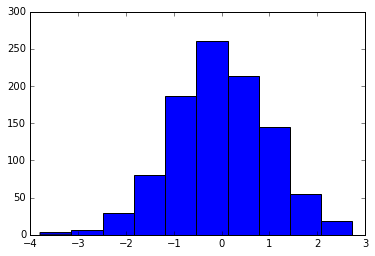

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4399173520> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4399173520> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4426046608> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4426046608> from matplotlib.figure.gca
10. Returning <AxesSubplot:4426046608> from matplotlib.pyplot.gca


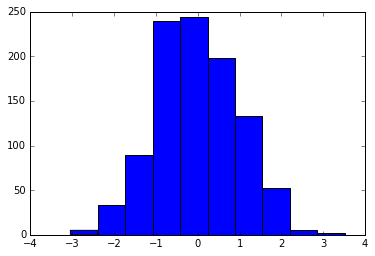

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4418129680> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4418129680> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4398398480> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4398398480> from matplotlib.figure.gca
10. Returning <AxesSubplot:4398398480> from matplotlib.pyplot.gca


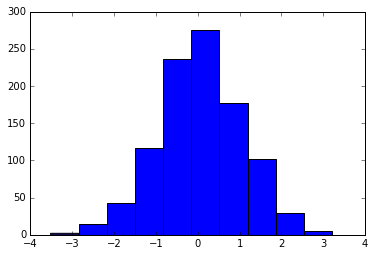

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4412403280> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4412403280> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4400059088> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4400059088> from matplotlib.figure.gca
10. Returning <AxesSubplot:4400059088> from matplotlib.pyplot.gca


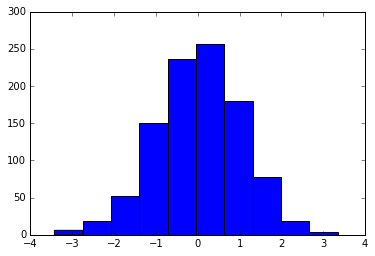

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4426428176> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4426428176> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4403561808> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4403561808> from matplotlib.figure.gca
10. Returning <AxesSubplot:4403561808> from matplotlib.pyplot.gca


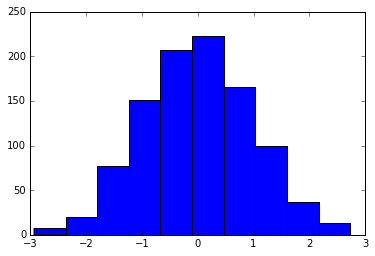

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4426575376> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4426575376> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4426723088> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4426723088> from matplotlib.figure.gca
10. Returning <AxesSubplot:4426723088> from matplotlib.pyplot.gca


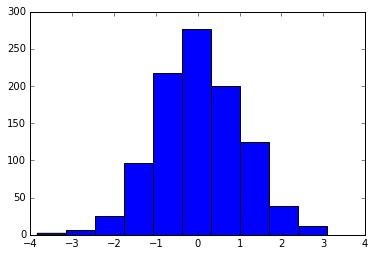

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4414323536> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4414323536> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4418360976> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4418360976> from matplotlib.figure.gca
10. Returning <AxesSubplot:4418360976> from matplotlib.pyplot.gca


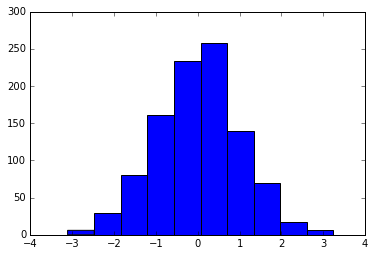

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4422606416> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4422606416> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4422489680> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4422489680> from matplotlib.figure.gca
10. Returning <AxesSubplot:4422489680> from matplotlib.pyplot.gca


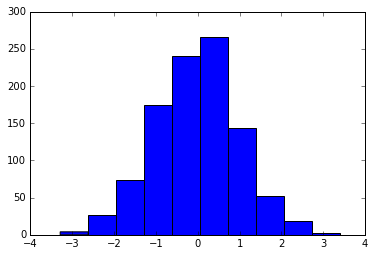

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4414341328> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4414341328> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4428253136> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4428253136> from matplotlib.figure.gca
10. Returning <AxesSubplot:4428253136> from matplotlib.pyplot.gca


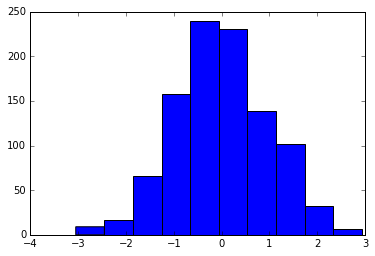

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------
 1. Calling matplotlib.pyplot.figure
 2. Returning <Figure:4400218000> from matplotlib.pyplot.figure
 3. Calling matplotlib.pyplot.gca
 4. |---Calling matplotlib.pyplot.gcf
 5. |---Returning <Figure:4400218000> from matplotlib.pyplot.gcf
 6. |---Calling matplotlib.figure.gca
 7. |-------Calling matplotlib.figure.add_subplot
 8. |-------Returning <AxesSubplot:4426494672> from matplotlib.figure.add_subplot
 9. |---Returning <AxesSubplot:4426494672> from matplotlib.figure.gca
10. Returning <AxesSubplot:4426494672> from matplotlib.pyplot.gca


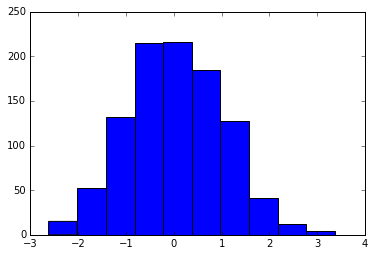

11. Calling matplotlib.pyplot.close
12. Returning <NoneType:4296531008> from matplotlib.pyplot.close
-------------------------------------------------------------------------------


In [10]:
for i in range(21):
    plt.figure()
    plt.hist(np.random.randn(1000))
    plt.show()
    print '-'*79
    println.reset()

In [11]:
plt.get_fignums()

[]